In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

from process import load_trace, METRICS_CONFIGS
sns.set_theme()

In [2]:
anomaly = "bpred"
metrics_config = 0
ANOMALY_NAME = "BPRED"

In [3]:
normal_df, _ = load_trace(anomaly, "xFTx.xx", metrics_config)
stress_df, _ = load_trace(anomaly, "xDTx.xx", metrics_config)
stress_df['CONTEXT'] = ANOMALY_NAME # Forced it after e-mail with Sylvain. Still waiting for a response.

In [4]:
stress_df

,TIMESTAMP,DURATION,L1D_CACHE,L1D_CACHE_REFILL,L1D_CACHE_WB,L2D_CACHE,L2D_CACHE_REFILL,L2D_CACHE_WB,CONTEXT
1,744665190516,102,1452,37,42,235,92,26,BPRED
2,744665190626,234,3895,27,31,301,150,33,BPRED
3,744665190868,66,1447,33,33,273,29,16,BPRED
4,744665190944,313,9810,31,48,246,89,19,BPRED
5,744665191268,40,583,10,10,78,29,9,BPRED
...,...,...,...,...,...,...,...,...,...
10498,751283051988,55735,2269913,2002,3132,13931,184,39,BPRED
10499,751283107733,55753,2260307,1996,2939,13415,411,35,BPRED
10500,751283163493,55737,2267081,2010,3003,13652,222,30,BPRED
10501,751283219238,55377,2259373,1744,2820,12670,49,27,BPRED


In [5]:
normal_df = (
    normal_df[['DURATION'] + METRICS_CONFIGS[metrics_config]].groupby(normal_df.index // 25).mean()
)
normal_df.insert(
    len(normal_df.axes), "CONTEXT", ["NOSTRESS" for _ in range(len(normal_df))]
)
stress_df = (
    stress_df[['DURATION'] + METRICS_CONFIGS[metrics_config]].groupby(stress_df.index // 25).mean()
)
stress_df.insert(
    len(stress_df.axes), "CONTEXT", [ANOMALY_NAME for _ in range(len(stress_df))]
)


In [6]:
normal_df

,DURATION,L1D_CACHE,CONTEXT,L1D_CACHE_REFILL,L1D_CACHE_WB,L2D_CACHE,L2D_CACHE_REFILL,L2D_CACHE_WB
0,42260.687500,1.719766e+06,NOSTRESS,447.066667,1077.987500,3529.487500,71.079167,59.091667
1,43105.262500,1.751182e+06,NOSTRESS,366.320833,947.875000,3003.579167,42.804167,71.283333
2,43248.020833,1.755706e+06,NOSTRESS,375.987500,955.750000,3035.270833,94.141667,43.270833
3,43407.779167,1.760695e+06,NOSTRESS,385.037500,972.287500,3096.545833,103.020833,42.820833
4,43513.600000,1.765294e+06,NOSTRESS,382.791667,968.716667,3073.712500,96.070833,40.454167
...,...,...,...,...,...,...,...,...
416,53804.870833,2.180796e+06,NOSTRESS,436.291667,1088.775000,3557.262500,82.900000,36.616667
417,53188.787500,2.155572e+06,NOSTRESS,444.575000,1098.679167,3608.241667,93.637500,38.366667
418,43095.604000,1.757050e+06,NOSTRESS,391.532000,1020.576000,3172.996000,80.596000,35.292000
419,48092.791667,1.948719e+06,NOSTRESS,403.145833,986.441667,3217.716667,91.479167,34.279167


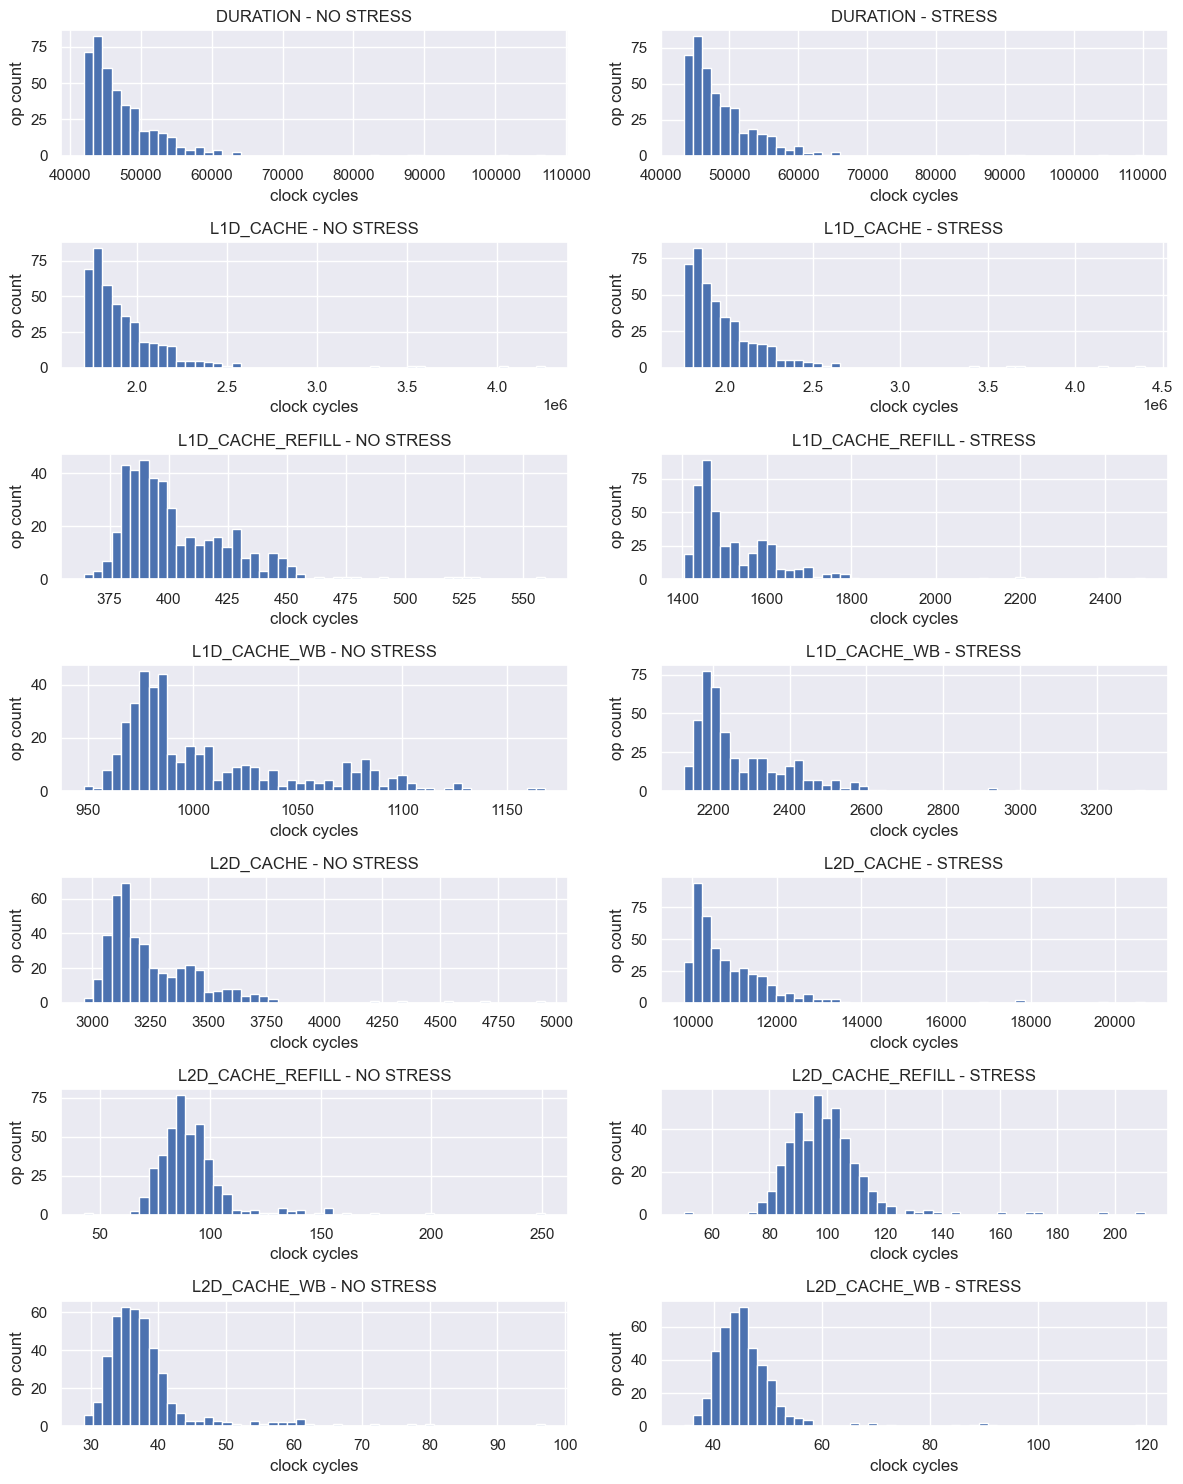

In [7]:
fig, axs = plt.subplots(7, 2, figsize=(12, 15))
for i, o in enumerate(['DURATION'] + METRICS_CONFIGS[metrics_config]):
    no_st_ax, st_ax = axs[i][0], axs[i][1]
    no_st_ax.set_title(f"{o} - NO STRESS")
    no_st_ax.set_xlabel("clock cycles")
    no_st_ax.set_ylabel("op count")
    st_ax.set_title(f"{o} - STRESS")
    st_ax.set_xlabel("clock cycles")
    st_ax.set_ylabel("op count")
    normal_df[o].hist(bins=50, ax=no_st_ax)
    stress_df[o].hist(bins=50, ax=st_ax)

plt.tight_layout()
plt.show()


In [8]:
predictors = ['L1D_CACHE_REFILL', 'L1D_CACHE_WB', 'L2D_CACHE']

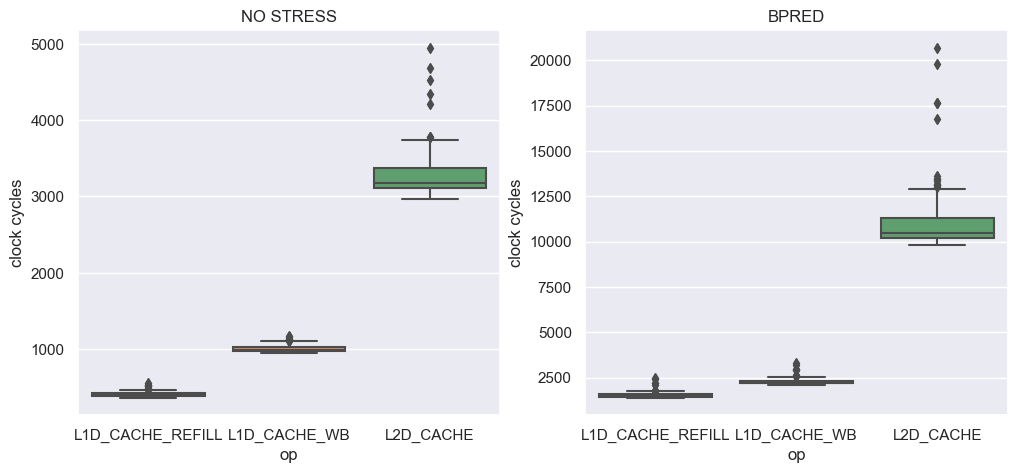

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x="variable", y="value", data=normal_df[predictors].melt(), ax=axs[0])
axs[0].set_title("NO STRESS")
axs[0].set_xlabel("op")
axs[0].set_ylabel("clock cycles")
sns.boxplot(x="variable", y="value", data=stress_df[predictors].melt(), ax=axs[1])
axs[1].set_xlabel("op")
axs[1].set_ylabel("clock cycles")
axs[1].set_title(ANOMALY_NAME)
plt.show()


In [10]:
def drop_quantile(df, q=0.1):
    cols = predictors  # one or more

    Q1 = df[cols].quantile(q)
    Q3 = df[cols].quantile(1 - q)
    IQR = Q3 - Q1

    df = df[
        ~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)
    ]
    return df


In [11]:
normal_df = drop_quantile(normal_df)
stress_df = drop_quantile(stress_df)
merged = pd.concat([normal_df, stress_df])
model = KMeans(n_clusters=2)
model.fit(merged[predictors])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

In [14]:
# Depending on what cluster represents NOSTRESS and what cluster represents bpred,
# we need to swap the labels.
labels = {"NOSTRESS": 0, ANOMALY_NAME: 1}


def test_fn(test_df, model):
    results = model.predict(test_df[predictors])
    y_true = test_df["CONTEXT"].to_numpy()
    y_true = [labels[y] for y in y_true]
    y_pred = results
    print(
        "Accuracy in regime prediction:",
        f"{round(accuracy_score(y_true, y_pred) * 100, 2)}%",
    )


In [15]:
test_fn(merged, model)

Accuracy in regime prediction: 100.0%


# Test xGTx.xx: intermittent anomaly

In [16]:
test_df, _ = load_trace(anomaly, "xGTx.xx", metrics_config)
test_df = test_df.reset_index(drop=True)
y_true = test_df["CONTEXT"].iloc[::25]
y_true = y_true.reset_index(drop=True)
test_df = test_df[['DURATION'] + METRICS_CONFIGS[metrics_config]].groupby(test_df.index // 25).mean()
test_df["CONTEXT"] = y_true


In [17]:
test_df

,DURATION,L1D_CACHE,L1D_CACHE_REFILL,L1D_CACHE_WB,L2D_CACHE,L2D_CACHE_REFILL,L2D_CACHE_WB,CONTEXT
0,43883.400000,1.787610e+06,1315.84,2096.920000,9493.360000,108.36,83.88,BPRED
1,44808.880000,1.821190e+06,1326.04,2092.560000,9687.640000,73.04,34.96,BPRED
2,45033.520000,1.827493e+06,1381.52,2146.640000,10196.360000,143.56,63.40,BPRED
3,45039.080000,1.830473e+06,1334.68,2096.760000,9702.440000,57.52,23.64,BPRED
4,45185.520000,1.835223e+06,1340.44,2094.600000,9744.120000,95.88,31.88,BPRED
...,...,...,...,...,...,...,...,...
4041,51652.080000,2.094303e+06,1518.24,2261.160000,10944.640000,51.44,18.56,BPRED
4042,50952.720000,2.065930e+06,1507.24,2263.440000,10815.600000,61.44,21.16,BPRED
4043,50307.800000,2.041113e+06,1479.40,2241.280000,10762.560000,53.92,20.80,BPRED
4044,49701.000000,2.017330e+06,1476.64,2232.880000,10604.920000,52.52,19.96,BPRED


In [18]:
normal_df

,DURATION,L1D_CACHE,CONTEXT,L1D_CACHE_REFILL,L1D_CACHE_WB,L2D_CACHE,L2D_CACHE_REFILL,L2D_CACHE_WB
0,42260.687500,1.719766e+06,NOSTRESS,447.066667,1077.987500,3529.487500,71.079167,59.091667
1,43105.262500,1.751182e+06,NOSTRESS,366.320833,947.875000,3003.579167,42.804167,71.283333
2,43248.020833,1.755706e+06,NOSTRESS,375.987500,955.750000,3035.270833,94.141667,43.270833
3,43407.779167,1.760695e+06,NOSTRESS,385.037500,972.287500,3096.545833,103.020833,42.820833
4,43513.600000,1.765294e+06,NOSTRESS,382.791667,968.716667,3073.712500,96.070833,40.454167
...,...,...,...,...,...,...,...,...
415,52272.495833,2.117847e+06,NOSTRESS,418.725000,1037.166667,3420.295833,79.845833,36.404167
416,53804.870833,2.180796e+06,NOSTRESS,436.291667,1088.775000,3557.262500,82.900000,36.616667
417,53188.787500,2.155572e+06,NOSTRESS,444.575000,1098.679167,3608.241667,93.637500,38.366667
418,43095.604000,1.757050e+06,NOSTRESS,391.532000,1020.576000,3172.996000,80.596000,35.292000


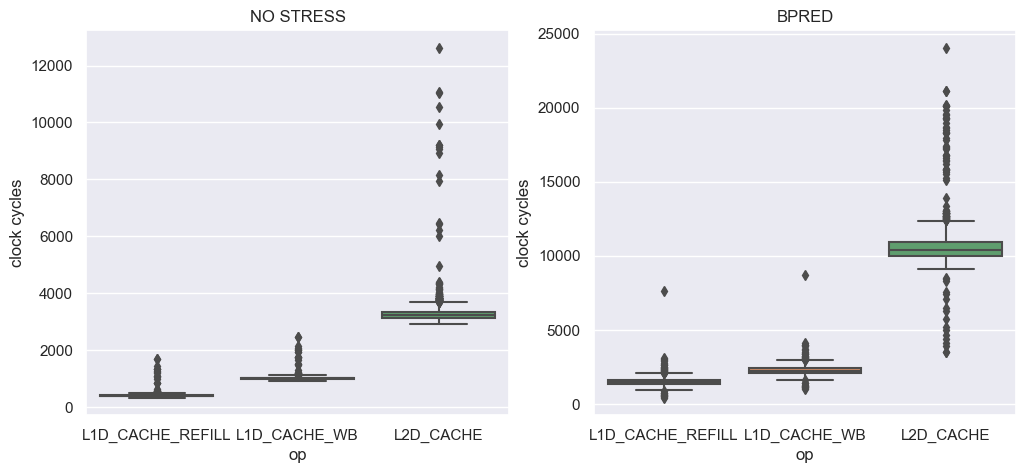

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
normal_df = test_df[test_df["CONTEXT"] == "NOSTRESS"]
stress_df = test_df[test_df["CONTEXT"] == ANOMALY_NAME]
sns.boxplot(x="variable", y="value", data=normal_df[predictors].melt(), ax=axs[0])
axs[0].set_title("NO STRESS")
axs[0].set_xlabel("op")
axs[0].set_ylabel("clock cycles")
sns.boxplot(x="variable", y="value", data=stress_df[predictors].melt(), ax=axs[1])
axs[1].set_xlabel("op")
axs[1].set_ylabel("clock cycles")
axs[1].set_title(ANOMALY_NAME)
plt.show()


In [20]:
test_fn(test_df, model)

Accuracy in regime prediction: 99.43%


In [21]:
import pickle

with open(f'models/{anomaly}.pkl', 'wb+') as f:
    pickle.dump({'headers': predictors, 'model': model}, f)